In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ray

from mdps.cliff import ContextualCliff
from utils.distributions import ConstantDistribution, ParticleDistribution

# Contextual cliff

This notebook studies using particle filtering to estimate the context parameters of a standard `Cliff` environment in `mdps.cliff`.

The `Cliff` environment has a cart that chooses either to go left or right for a `step_size`. It starts at the `mid_point` of the `right_end` and the `left_end` and receives a reward that proportional to the power (default set to 2) of its current location, `x`. If it "falls off the cliff" from the left or right end, however, it receives a negative reward and the episode ends. Also, there are noise and drift terms, so the state-transition equation of the position `x` is (where `action` is 0 or 1 for moving left or right):
\
$x_{t+1} = N(0, \text{noise}) - \text{drift} * x + 2 * (\text{action}-0.5) * \text{stepsize}$

Thus, the goal of the cart is to be as large as possible (i.e. close to the larger end) and in the meantime keep a distance to the end to prevent accidentally falling off due to the noise.

The context params are: `(left_bound, right_bound, pow, step_size, noise, drift)`.

# Set target

We first create a target config, $c$. This will be the $MDP(c)$ the expert uses to generate the observational data.

In [2]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                         [0.0, 3.0, 2.0, 0.025, 0.05, 0.0]
c = {'context_distribution':
         ConstantDistribution(dim=6,
                              constant_vector=np.array([0.0, 3.0, 2, 0.025, 0.05, 0.0]))}

First, train an expert that masters this context.

In [3]:
from ray.rllib.agents import ppo

ray.shutdown()
ray.init()
expert = ppo.PPOTrainer(env=ContextualCliff, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(20):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-02-12 16:38:07,639	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-12 16:38:08,635	INFO ppo.py:167 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-12 16:38:08,635	INFO trainer.py:745 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-02-12 16:38:10,037	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 16.149009886346263
1 19.288710011624936
2 24.865955626008677
3 32.87139284258445
4 37.12272453884709
5 41.86892229893513
6 45.83578321905008
7 48.49346665638398
8 52.80230781296268
9 59.74394435105435
10 66.57194139223898
11 73.90664201731825
12 75.73521271110168
13 72.7813953408177
14 65.14444809101433
15 63.82354180390417
16 67.11662378187515
17 70.45755143567833
18 77.46425480465899
19 82.49614835558043


In [4]:
# collect expert rollout
env = ContextualCliff(config=c)
done = False
obs = env.reset()
# run until episode ends
gt_obs_arr = None
gt_act_arr = None
while not done:
    action = expert.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    if gt_obs_arr is None:
        gt_obs_arr = obs
        gt_act_arr = [action]
    else:
        gt_obs_arr = np.vstack((gt_obs_arr, obs))
        gt_act_arr += [action]

gt_act_arr = np.array(gt_act_arr)

In [5]:
gt_obs_arr.shape

(100, 7)

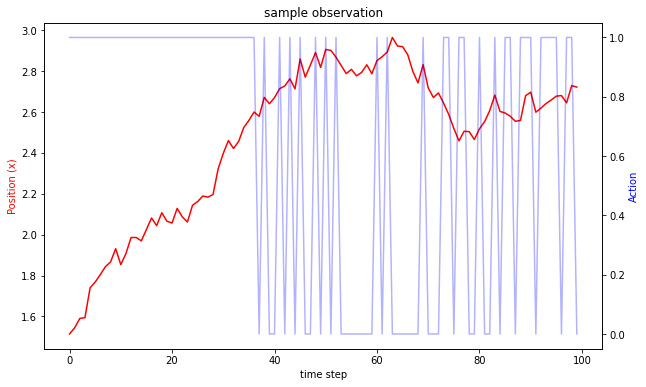

In [6]:
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6, forward=True)

x = np.arange(start=0, stop=gt_obs_arr.shape[0])
ax2 = ax1.twinx()
ax1.plot(x, gt_obs_arr[:, 0], 'r-')
ax2.plot(x, gt_act_arr, 'b-', alpha=0.3)

ax1.set_xlabel('time step')
ax1.set_ylabel('Position (x)', color='r')
ax2.set_ylabel('Action', color='b')
plt.title('sample observation')
plt.show()

## Exact context

We first train a RL solver only on the correct context for particle filtering. We have already done this so we can directly use the expert solver.

In [11]:
# true (expert) context: (left_bound, right_bound, pow, step_size, noise, drift) =
#                       [0.0, 3.0, 2.0, 0.025, 0.05, 0.0]

N = 2000
T = 100
left_bound = np.random.normal(loc=0, scale=0.001, size=(N,))
right_bound = np.random.normal(loc=2.5, scale=0.5, size=(N,))
pow = np.ones((N,)) * 2
step_size = np.ones((N,)) * 0.025
noise = np.ones((N,)) * 0.05
drift = np.random.normal(loc=0.00, scale=0.001, size=(N,))

context_particles = np.vstack((left_bound, right_bound, pow, step_size, noise, drift)).T
context_particles = np.abs(context_particles)
context_distribution = ParticleDistribution(dim=6, particles=context_particles, n_particles=N)

In [12]:
solver = expert
state_arr = np.zeros((N,))
action_arr = np.zeros((N,))
context_history = []
for t in range(T):
    # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
    qs = np.zeros((N,))
    for n in range(N):
        context = context_distribution.particles[n]
        if context[4] < 0:
            qs[n] = 0
            state_arr[n] = np.copy(env.mdp.x)
            continue
        c_local = {'context_distribution':
                       ConstantDistribution(dim=6,
                                            constant_vector=context)}
        env = ContextualCliff(config=c_local)
        done = False
        obs = env.reset()
        if t > 0:
            env.mdp.x = state_arr[n]
            obs = np.concatenate((np.array([env.mdp.x]), context), axis=0).flatten()
        action = solver.compute_single_action(obs)
        obs, reward, done, info = env.step(action)
        # estimate likelihood if r >= 1
        if t >= 1:
            q = env.likelihood(gt_obs_arr[t - 1], action_arr[n], obs)
            qs[n] = q
        state_arr[n] = np.copy(env.mdp.x)
        action_arr[n] = action
    if t >= 1:
        # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
        qs = np.clip(qs, 0, np.percentile(qs, 90))
        qs = qs / qs.sum()
        resample_index = context_distribution.resample_particles_from_probability(p=qs)
        p_temp = context_distribution.particles
        pnoise = np.random.normal(loc=0, scale=p_temp.std(axis=0), size=p_temp.shape) * 0.05
        context_distribution.particles += pnoise
        state_arr = state_arr[resample_index]
        action_arr = action_arr[resample_index]
    if t % 10 == 0:
        print(t, context_distribution.particles[:, 1].mean())
    context_history += [context_distribution.particles.copy()]

0 2.5012662327480895
1 2.931878168538389
2 2.9374707003387903
3 2.9453379938473234
4 2.941073310566251
5 2.9430541828303887
6 2.9418377419087745
7 2.945795643521889
8 2.93867247882648
9 2.939584813026817
10 2.935499047467519
11 2.9398211027719245
12 2.9411516978121863
13 2.9403835727740972
14 2.9373796773807466
15 2.9412614326613946
16 2.937547292271213
17 2.9379915719986784
18 2.9355591670110317
19 2.9363978384151252
20 2.9341058611143116
21 2.9337228864782654
22 2.9341815533975444
23 2.9397167986770945
24 2.937122296870585
25 2.9386380779183483
26 2.940215889463464
27 2.9424871008946174
28 2.946769745454182
29 2.950081468373319
30 2.9529349650285677
31 2.9587051904022963
32 2.9562943342465577
33 2.953439464552839
34 2.9616221444105575
35 2.9662291732753
36 2.9774098410843695
37 2.9842427536666856
38 2.976251573398023
39 2.985497496768405
40 2.986204756965466
41 2.9876352572163696
42 3.003422780841636
43 3.0158978146381226
44 3.024916623563685
45 3.0271897358088027
46 3.05259917912426

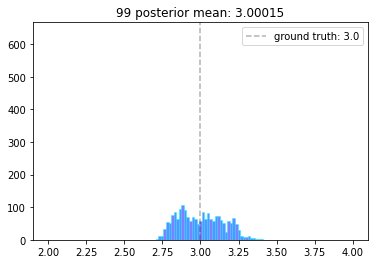

In [13]:
from matplotlib import animation

HIST_BINS = np.linspace(2, 4, 120)


def prepare_animation(bar_container_):
    def animate(frame_number, data=context_history):
        # simulate new data coming in
        x = data[frame_number][:, 1]
        n, _ = np.histogram(x, HIST_BINS)
        plt.title(f'{frame_number} posterior mean: {round(x.mean(), 5)}')
        for count, rect in zip(n, bar_container_.patches):
            rect.set_height(count)
        return bar_container_.patches

    return animate


fig, ax = plt.subplots()
plt.axvline(x=3, alpha=0.3, color='black', linestyle='--')
plt.legend(['ground truth: 3.0'])
_, _, bar_container = ax.hist(context_history[0][:, 1], HIST_BINS, lw=1,
                              ec="cyan", fc="blue", alpha=0.5)
ax.set_ylim(top=N / 3)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, prepare_animation(bar_container), len(context_history),
                              repeat=True, blit=False, interval=100, repeat_delay=500)
prior_mean = 2.5
posterior_mean = round(context_history[-1][:, 1].mean(), 3)
ani.save(f'prior_{prior_mean}_posterior{posterior_mean}.mp4', dpi=300)
plt.show()

# Mis-specified context

We also see what happens if we train a solver only on an MDP $MDP(c_{miss})$, where $c_{miss}$ is a mis-specified context.

In [35]:
# We try a short cartpole on a planet with g=5.0. We also slightly reduce noise to 0.1.
c_mis = {'context_distribution':
             ConstantDistribution(dim=5,
                                  constant_vector=np.array([0.0, 3.0, 2.0, 0.025, 0.05, 0.0]))}

ray.shutdown()
ray.init()
mis_solver = ppo.PPOTrainer(env=ContextualCliff, config={
    "env_config": c_mis,
    "framework": "torch",  # config to pass to env class
})

for eps in range(20):
    res = mis_solver.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])

2022-02-07 13:48:02,099	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-02-07 13:48:04,570	WARNING util.py:57 -- Install gputil for GPU system monitoring.


0 16.520661157024794
1 29.116788321167885
2 46.22
3 68.62
4 90.35
5 115.09
6 130.48
7 151.13
8 172.98
9 187.48
10 204.04
11 216.97
12 243.83
13 262.72
14 293.09
15 312.45
16 350.85
17 376.13
18 390.21
19 418.78
20 473.69
21 486.92
22 525.33
23 525.33
24 551.49
25 649.67
26 688.52
27 688.52
28 718.98
29 718.98
